In [3]:
import pickle
import math
import numpy as np
import pandas as pd

import urllib.parse
from sqlalchemy import create_engine
import psycopg2

from sklearn.model_selection import train_test_split
# remove unused accuracy score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

import sys, os
# Add location of config.py in grandparent folder to sys.path
sys.path.append(os.path.abspath(os.path.join('../..')))
from config import db_password

In [4]:
# # Set seaborn theme
# sns.set_style('darkgrid', {
#     'grid.linestyle': ':',
#     'grid.linewidth': 1.0})

# plt.style.use('dark_background')

### Load Data from Provisional Database

In [5]:
# Store SQL connection string
db_string = f"postgresql://user:{urllib.parse.quote(db_password)}\
@127.0.0.1:5432/disease_prediction"

# # Connect to SQL database
# # Use 'with' to let Python's context manager call Connection.close()
# with create_engine(db_string).connect() as engine:
#     # Load table from database into DataFrame
#     data_df = pd.read_sql('dataset_clean', engine)

In [6]:
# Load data locally for testing
data_df = pd.read_csv('./Data/Cleaned/dataset_clean.csv')

data_df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,fungal infection,itching,skin rash,nodal skin eruptions,mottling skin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fungal infection,skin rash,nodal skin eruptions,mottling skin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fungal infection,itching,nodal skin eruptions,mottling skin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fungal infection,itching,skin rash,mottling skin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,fungal infection,itching,skin rash,nodal skin eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Transform DataFrame to Boolean per Symptom

In [7]:
# List of symptom column names from data_df
symptom_cols = data_df.columns.to_list()[1:]

# Get values from symptom columns as an array
symptom_values = data_df[symptom_cols].values.astype(str)

# Get list of unique values from array
symptom_list = list(np.unique(symptom_values))
symptom_list.remove('nan')

In [8]:
# Create boolean DataFrame
bool_df = data_df.reindex(columns=['Disease'] + symptom_list)

# Apply boolean values to bool_df according to presence in data_df row
for col in bool_df[symptom_list]:
    bool_df[col] = [True if np.isin(row, col).any() else False
                    for row in data_df[symptom_cols].to_numpy()]

# Check that no NaN's remain
print(bool_df.isnull().any().any())
bool_df

False


,Disease,abdominal pain,abnormal menstruation,acidity,acute liver failure,altered mental state,anxiety,back pain,belly pain,blackheads,...,vomiting,watering from eyes,weakness in limbs,weakness of one body side,weight gain,weight loss,yellow oozing scabs,yellow urine,yellowing of eyes,yellowish skin
0,fungal infection,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,fungal infection,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,fungal infection,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,fungal infection,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,fungal infection,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,paroxysmal positional vertigo,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4916,acne,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4917,urinary tract infection,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4918,psoriasis,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
# Save boolean DataFrame
bool_df.to_csv('./Data/Cleaned/dataset_bool.csv')

### Split Data into Training and Testing

In [10]:
# Split into features and target arrays
y = bool_df['Disease'].values
X = bool_df.drop(columns=['Disease']).values

In [11]:
# Split into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=2718281828   # math constant e
)

### Compile Machine Learning Model

<!-- ##### Particularly in high-dimensional spaces, data can more easily be separated linearly and the simplicity of classifiers such as naive Bayes and linear SVMs might lead to better generalization than is achieved by other classifiers. -->

In [ ]:
# Random Forest Classifier
rfc = RandomForestClassifier(
    n_estimators=128,
    random_state=2718281828,
    # max_features=None # default 'sqrt'
    # max_depth=5       # default None
)
rfc.fit(X_train, y_train)
rfc_predict = rfc.predict(X_test)

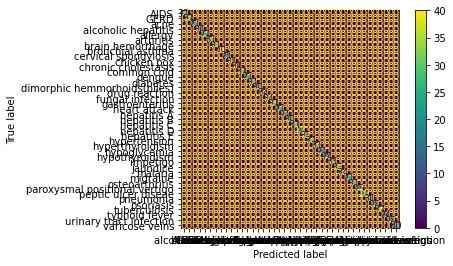

In [12]:
# Generate confusion matrix
rfc_cm = confusion_matrix(y_test, rfc_predict)

rfc_display = ConfusionMatrixDisplay(confusion_matrix=rfc_cm,
    display_labels=rfc.classes_)

rfc_display.plot()
# This needs to be made legible

# plt.savefig('./Images/rfc_confusion_matrix.png')

In [30]:
# Save trained model to Pickle file
pickle.dump(rfc, open('./Models/rfc_model.pkl', 'wb'))

In [26]:
# Create array of random symptoms
test = np.random.randint(2, size=len(symptom_list))
test

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1])

In [28]:
# Predict disease
rfc.predict(test.reshape(1, -1))

array(['common cold'], dtype=object)

In [18]:
# Calculate accuracy score
accuracy_score(y_test, rfc_predict)

# 1.0 is improbably high, model may not be interpreting data correctly?

1.0

In [ ]:
# Show sorted feature importances
# sorted(zip(rfc.feature_importances_, bool_df[symptom_list].columns), reverse=True)

In [ ]:
# Support Vector Classification
rbf_svm = SVC()
rbf_svm.fit(X_train, y_train)
rbf_svm.predict(X_test)

In [ ]:
# sklearn neural network
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp.predict(X_test)

In [ ]:
# Keras neural network
nn = Sequential()

# Neural network layers

nn.fit(X_train, y_train)
nn.predict(X_test)

In [ ]:
# Output labels for input data
y_pred_rfc = rfc.predict(X_test)

y_pred_svm = rbf_svm.predict(X_test)

y_pred_mlp = mlp.predict(X_test)

y_pred_nn = nn.predict_classes(X_test)